In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.datasets import fashion_mnist
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

## Частина 1 ##

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

### __Допоміжні функції__ ###

In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)


set_seed(42)


def loss_accuracy_plotting(history: dict, title: str=None, title_y=1.1):
    num_epochs = len(history[list(history.keys())[0]])

    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, num_epochs//10)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                                   gridspec_kw={"wspace": 0.2})

    ax1.plot(x, history["loss"])
    ax1.plot(x, history["val_loss"])
    ax1.set_title("loss and val_loss")

    ax2.plot(x, history["categorical_accuracy"])
    ax2.plot(x ,history["val_categorical_accuracy"])
    ax2.set_title("accuracy and val_accuracy")

    ax1.grid(True)
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")

    ax2.grid(True)
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")

    if title:
        fig.suptitle(title, y=title_y)
    plt.show()

### __Декілька класів для зменшення строчок коду__ ###

In [4]:
class FashionData:
    def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        self.x_test = x_test
        self.y_test = y_test


class HyperParameters:
    def __init__(self, batch_size:int = 384, n_epochs = 30, optimizer=None):
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.optimizer = optimizer if optimizer else Adam(learning_rate=0.0006)


class FashionModel:
    def __init__(self, layers: list, hp: HyperParameters):
        self.history = {}

        self.batch_size = hp.batch_size
        self.n_epochs = hp.n_epochs
        self.optimizer = hp.optimizer

        self.model = Sequential()
        for layer in layers:
            self.model.add(layer)
        self.model.compile(optimizer=self.optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

    def evaluate(self, fd:FashionData):
        if self.history:
            score_train = self.model.evaluate(fd.x_train, fd.y_train, verbose=0)
            score_test = self.model.evaluate(fd.x_test, fd.y_test, verbose=0)
            print(f"Train loss: {score_train[0]}, train accuracy: {score_train[1]}")
            print(f"Test loss:  {score_test[0]}, test accuracy:  {score_test[1]}")

            print("\nTrain")
            print(f"Min loss : {np.array(self.history['loss']).min()}, "
                  f"epoch num: {np.argmin(self.history['loss']) + 1}")
            print(f"Max accuracy : {np.array(self.history['categorical_accuracy']).max()}, "
                  f"epoch num: {np.argmax(self.history['categorical_accuracy']) + 1}")
            print("\nValidation")
            print(f"Min loss : {np.array(self.history['val_loss']).min()}, "
                  f"epoch num: {np.argmin(self.history['val_loss']) + 1}")
            print(f"Max accuracy : {np.array(self.history['val_categorical_accuracy']).max()}, "
                  f"epoch num: {np.argmax(self.history['val_categorical_accuracy']) + 1}")

    def fit(self, fd:FashionData) -> dict:
        self.history = (self.model.fit(x=fd.x_train, y=fd.y_train, batch_size=self.batch_size,
                                       epochs=self.n_epochs, validation_data=(fd.x_valid, fd.y_valid), verbose=0)).history

    def fit_augm(self, fd:FashionData, datagen:ImageDataGenerator) -> dict:
        self.history = (self.model.fit(datagen.flow(fd.x_train, fd.y_train, batch_size=self.batch_size),
                                      shuffle=True, epochs=self.n_epochs,
                                      validation_data = (fd.x_valid, fd.y_valid),
                                      verbose = 1, steps_per_epoch=fd.x_train.shape[0] // self.batch_size,
                                      use_multiprocessing=True)).history


    def summary(self, full_info=False):
        if full_info:
            self.model.summary()
        else:
            trainable_params = np.sum([np.prod(v.get_shape()) for v in self.model.trainable_weights])
            non_trainable_params = np.sum([np.prod(v.get_shape()) for v in self.model.non_trainable_weights])
            total_params = trainable_params + non_trainable_params
            print("="*60)
            print(f"Total params: {int(total_params)}")
            print(f"Trainable params: {int(trainable_params)}")
            print(f"Non-trainable params: {int(non_trainable_params)}")
            print("_"*60)


### __Підготовка вже знайомих з минулого ДЗ данних__ ###

In [5]:
(x_train_valid, y_train_valid), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = \
    train_test_split(x_train_valid, y_train_valid, test_size=0.1, shuffle=True, stratify=y_train_valid)

# Нормалізуемо значення пікселів
x_train = x_train.astype(np.float32) / 255.
x_valid = x_valid.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

# Решейпинг
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# # Категорізуємо наші класи
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_valid_cat = keras.utils.to_categorical(y_valid, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

fashion_data = FashionData(x_train, y_train_cat, x_valid, y_valid_cat, x_test, y_test_cat)

### __Перша спроба з одним конвуляційним та одним повнозв'язним шаром__ ###

In [8]:
layers_01 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_01, HyperParameters(n_epochs=50))

model.summary(full_info=False)

Total params: 804554
Trainable params: 804554
Non-trainable params: 0
____________________________________________________________


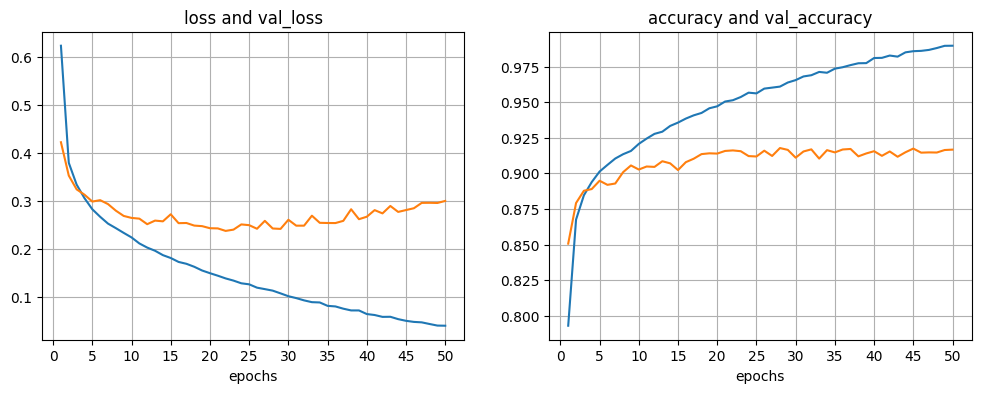

Train loss: 0.08877722918987274, train accuracy: 0.9759259223937988
Test loss:  0.3341755270957947, test accuracy:  0.9133999943733215

Train
Min loss : 0.040446408092975616, epoch num: 50
Max accuracy : 0.9896296262741089, epoch num: 50

Validation
Min loss : 0.23780587315559387, epoch num: 22
Max accuracy : 0.9177777767181396, epoch num: 28


In [11]:
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

__Маємо дуже наглядний приклад перенавчання мережі починаючи приблизно з 22 епохи.__

### __Подивимось на результат без Conv2D шару.__ ###

Total params: 101770
Trainable params: 101770
Non-trainable params: 0
____________________________________________________________


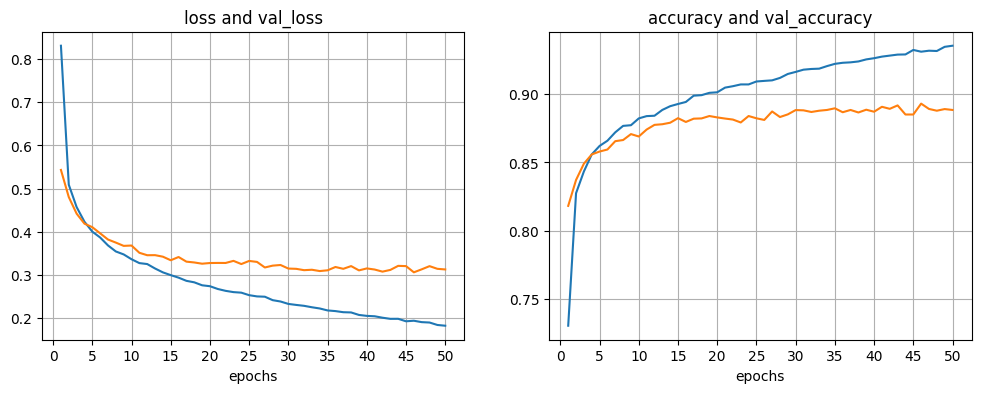

Train loss: 0.20308469235897064, train accuracy: 0.9281851649284363
Test loss:  0.33779385685920715, test accuracy:  0.8830000162124634

Train
Min loss : 0.18228241801261902, epoch num: 50
Max accuracy : 0.9354861378669739, epoch num: 50

Validation
Min loss : 0.30597808957099915, epoch num: 46
Max accuracy : 0.8930555582046509, epoch num: 46


In [12]:
layers_01_old = [
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_01_old, HyperParameters(n_epochs=50))

model.summary(full_info=False)
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

__Бачимо, що без конвуляційного шару мережа має гірший показник точності, що може свідчити про гіршу якість фічерів на вході повнозв'язного шару. Але відмічаємо також суттєво меншу кількість параметрів мережі: 104_770 проти 804_554__

### __Добавимо в CNN мережу ще один Conv2D шар.__ ###

In [20]:
layers_02 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_02, HyperParameters(n_epochs=50))

model.summary(full_info=False)

Total params: 813802
Trainable params: 813802
Non-trainable params: 0
____________________________________________________________


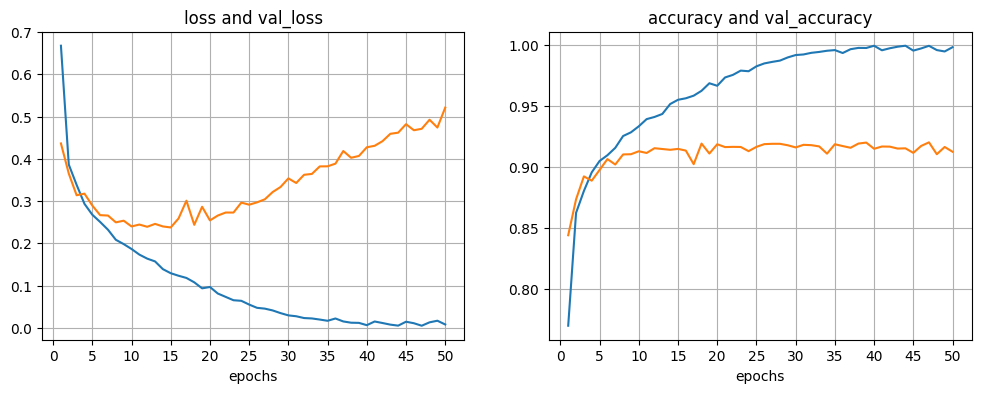

Train loss: 0.11878970265388489, train accuracy: 0.977055549621582
Test loss:  0.5786017775535583, test accuracy:  0.9096999764442444

Train
Min loss : 0.004794680513441563, epoch num: 47
Max accuracy : 0.9992592334747314, epoch num: 44

Validation
Min loss : 0.23747043311595917, epoch num: 15
Max accuracy : 0.9201852083206177, epoch num: 47


In [21]:
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

__Перенавчення прогресує. Глянемо як на поведінку моделі вплине BatchNormalization__  

In [24]:
layers_03 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_03, HyperParameters(n_epochs=50))

model.summary(full_info=False)

Total params: 814058
Trainable params: 813930
Non-trainable params: 128
____________________________________________________________


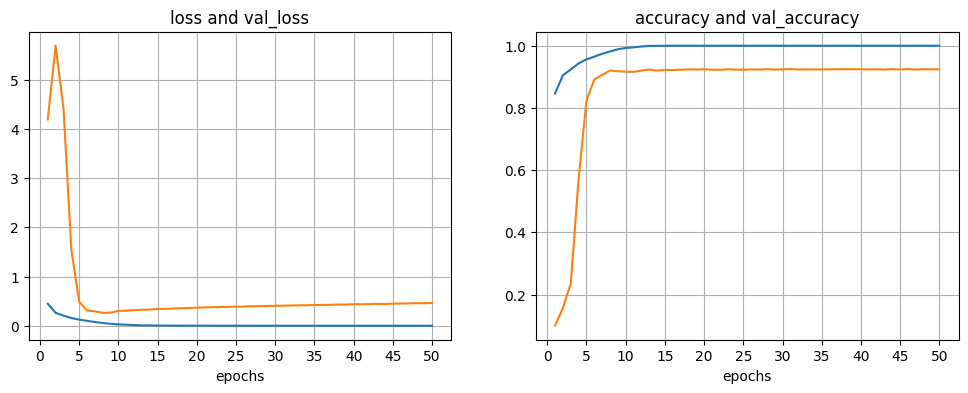

Train loss: 0.09237027913331985, train accuracy: 0.9848148226737976
Test loss:  0.4961528778076172, test accuracy:  0.9236000180244446

Train
Min loss : 4.4016644096700475e-05, epoch num: 50
Max accuracy : 1.0, epoch num: 17

Validation
Min loss : 0.2615290582180023, epoch num: 8
Max accuracy : 0.9248148202896118, epoch num: 46


In [25]:
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

__Явне пришвидшення перенавчання, а результат на трейні просто вражаючий. Жаль, що орієнтуємося не на нього.  
Спробуємо подати на вхід повнозв'язного шару більш узагальнені фічі додавши ще декілька Conv2D шарів а також бонусом зменшимо загальну кількість параметрів.__

In [28]:
layers_04 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_04, HyperParameters(n_epochs=50))

model.summary(full_info=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                     

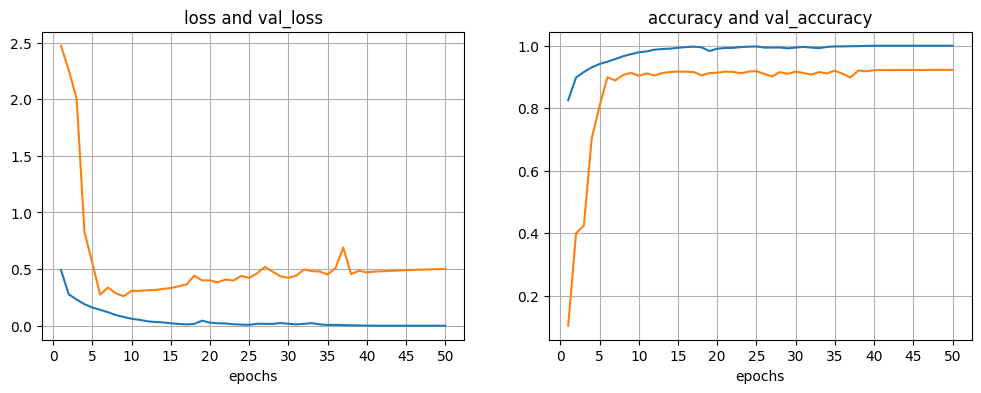

Train loss: 0.10026621073484421, train accuracy: 0.9845185279846191
Test loss:  0.5774497389793396, test accuracy:  0.9180999994277954

Train
Min loss : 3.12494084937498e-05, epoch num: 50
Max accuracy : 1.0, epoch num: 41

Validation
Min loss : 0.2608209550380707, epoch num: 9
Max accuracy : 0.922870397567749, epoch num: 48


In [29]:
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

### __Настав час поборотися з перенавчанням, використовуючи технологію Dropout__ ###

In [30]:
layers_05 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_05, HyperParameters(n_epochs=50))

model.summary(full_info=False)

Total params: 251818
Trainable params: 251306
Non-trainable params: 512
____________________________________________________________


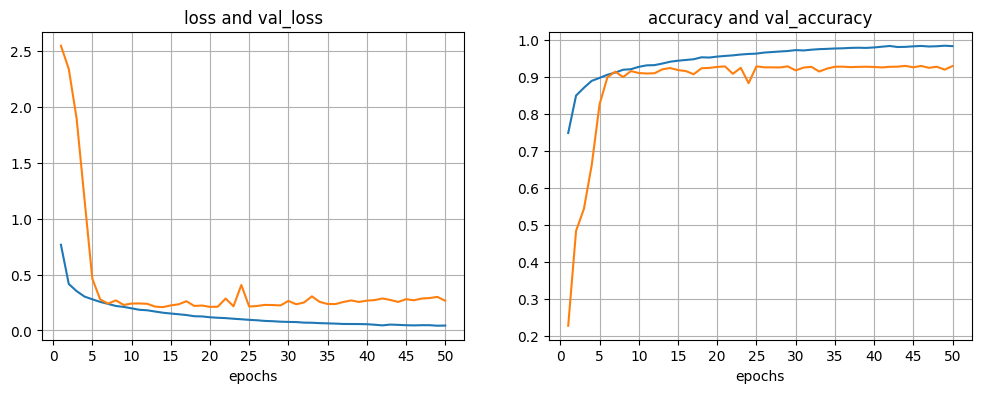

Train loss: 0.06457677483558655, train accuracy: 0.982796311378479
Test loss:  0.30503031611442566, test accuracy:  0.9207000136375427

Train
Min loss : 0.04243766888976097, epoch num: 49
Max accuracy : 0.9840046167373657, epoch num: 49

Validation
Min loss : 0.2086074948310852, epoch num: 14
Max accuracy : 0.9296296238899231, epoch num: 44


In [31]:
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

__Фіксуємо рух в правильному напрямку__

In [32]:
layers_06 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_06, HyperParameters(n_epochs=50))

model.summary(full_info=False)

Total params: 251818
Trainable params: 251306
Non-trainable params: 512
____________________________________________________________


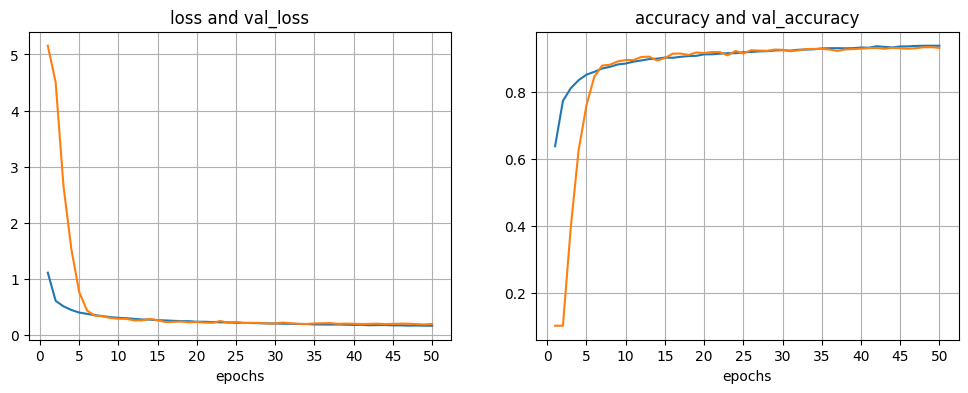

Train loss: 0.12792187929153442, train accuracy: 0.9544259309768677
Test loss:  0.21191754937171936, test accuracy:  0.9261000156402588

Train
Min loss : 0.16598257422447205, epoch num: 50
Max accuracy : 0.9378935098648071, epoch num: 49

Validation
Min loss : 0.18926884233951569, epoch num: 49
Max accuracy : 0.9336110949516296, epoch num: 49


In [33]:
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

__Не знаю чому, але мені дуже подобаються графіки, на яких train зливається з val__

### __Як варіант можна було ще погратися з повнозв'язними шарами та дропаутами, але краще глянемо на аугментацію.__ ###

__Чесно скопіпастимо набір трансформацій з Kaggle в надії, що автор відповідально підійшов до їх вибру.__

In [41]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.1,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

Так як один з результатів аугментації зменшення перенавчання - то трохи ослабимо дропаути в шарах

In [42]:
layers_07 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_07, HyperParameters(n_epochs=50))

model.summary(full_info=False)

Total params: 251818
Trainable params: 251306
Non-trainable params: 512
____________________________________________________________


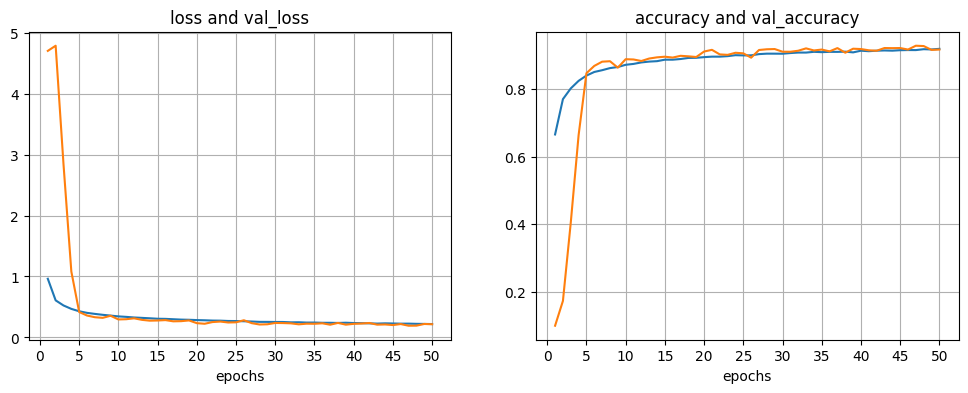

Train loss: 0.09476904571056366, train accuracy: 0.9649074077606201
Test loss:  0.20141662657260895, test accuracy:  0.9319999814033508

Train
Min loss : 0.2197389006614685, epoch num: 50
Max accuracy : 0.9184385538101196, epoch num: 50

Validation
Min loss : 0.19225704669952393, epoch num: 47
Max accuracy : 0.9276666641235352, epoch num: 47


In [48]:
model.fit_augm(fashion_data, datagen)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

__Відмічаємо, що точність стала трохи кращою, але час на тренування виріс на порядок. Можливо краще було б сформувати трасформації окремо та працювати з трансформованими зображеннями в датасеті.__

In [60]:
model.model.save("augm_model")

In [51]:
model_loaded = keras.models.load_model("augm_model")

In [52]:
pred_test = model_loaded.predict(x_test)
acc_test = categorical_accuracy(y_test_cat, pred_test).numpy().mean()
print(f"Точність по всьому тестовому датасеті: {acc_test}")

313/313 [==============================] - 1s 2ms/step
Точність по всьому тестовому датасеті: 0.9319999814033508


### __Матриця помилок__ ###

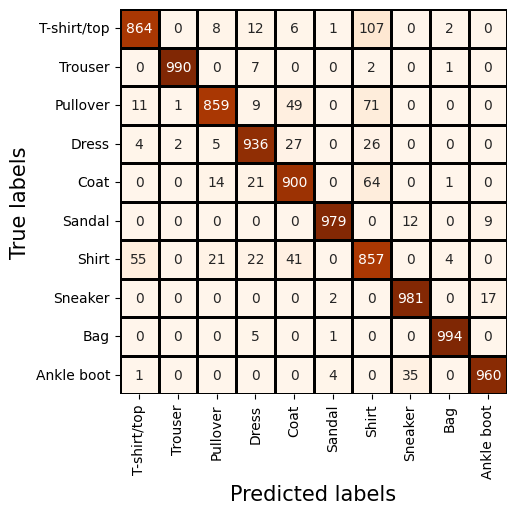

In [53]:
labels = ["T-shirt/top",
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Ankle boot"]

y_pred = tf.argmax(pred_test, axis=1)

cm = confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

### __Точність по класам__ ###

In [65]:
true_idx = np.where(y_test == y_pred)[0]
all_data = pd.DataFrame(y_test.reshape(-1,1), columns=["Label"]).groupby("Label")["Label"].count()
true_data = pd.DataFrame(y_test[[true_idx ]].reshape(-1,1), columns=["Label"]).groupby("Label")["Label"].count()
accuracy_data = pd.DataFrame({"all_cnt": all_data, "true_cnt": true_data})
accuracy_data["false_cnt"] = accuracy_data["all_cnt"] - accuracy_data["true_cnt"]
accuracy_data["accuracy"] = accuracy_data["true_cnt"] / accuracy_data["all_cnt"]
accuracy_data.index = labels
display(accuracy_data.sort_values("accuracy"))

,all_cnt,true_cnt,false_cnt,accuracy
Shirt,1000,857,143,0.857
Pullover,1000,859,141,0.859
T-shirt/top,1000,864,136,0.864
Coat,1000,900,100,0.900
Dress,1000,936,64,0.936
Ankle boot,1000,960,40,0.960
Sandal,1000,979,21,0.979
Sneaker,1000,981,19,0.981
Trouser,1000,990,10,0.990
Bag,1000,994,6,0.994


### __Аугментація не вразила, тому не втримався, щоб не глянути на мережу з двома повнозв'язними шарами__ ###

In [58]:
layers_08 = [
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(10, activation="softmax"),
]

model = FashionModel(layers_08, HyperParameters(n_epochs=70))

model.summary(full_info=False)

Total params: 432298
Trainable params: 431786
Non-trainable params: 512
____________________________________________________________


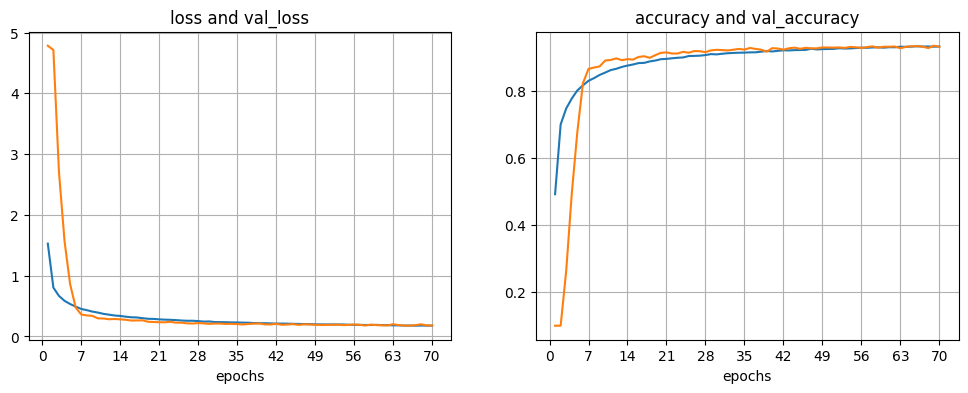

Train loss: 0.11969602853059769, train accuracy: 0.9568889141082764
Test loss:  0.1975478082895279, test accuracy:  0.9311000108718872

Train
Min loss : 0.17570698261260986, epoch num: 67
Max accuracy : 0.9349074363708496, epoch num: 66

Validation
Min loss : 0.1769886463880539, epoch num: 66
Max accuracy : 0.9365741014480591, epoch num: 69


In [59]:
model.fit(fashion_data)
loss_accuracy_plotting(model.history)
model.evaluate(fashion_data)

### __Вибираю цю модель по критерію швидкість-точність__ ###

In [61]:
model.model.save("best_model")

In [63]:
model_last = keras.models.load_model("best_model")

__Точність по тестовому набору__

In [64]:
pred_test = model_last.predict(x_test)
acc_test = categorical_accuracy(y_test_cat, pred_test).numpy().mean()
print(f"Точність по всьому тестовому датасеті: {acc_test}")

313/313 [==============================] - 1s 2ms/step
Точність по всьому тестовому датасеті: 0.9311000108718872


__Точність по класам__

In [66]:
true_idx = np.where(y_test == y_pred)[0]
all_data = pd.DataFrame(y_test.reshape(-1,1), columns=["Label"]).groupby("Label")["Label"].count()
true_data = pd.DataFrame(y_test[[true_idx ]].reshape(-1,1), columns=["Label"]).groupby("Label")["Label"].count()
accuracy_data = pd.DataFrame({"all_cnt": all_data, "true_cnt": true_data})
accuracy_data["false_cnt"] = accuracy_data["all_cnt"] - accuracy_data["true_cnt"]
accuracy_data["accuracy"] = accuracy_data["true_cnt"] / accuracy_data["all_cnt"]
accuracy_data.index = labels
display(accuracy_data.sort_values("accuracy"))

,all_cnt,true_cnt,false_cnt,accuracy
Shirt,1000,857,143,0.857
Pullover,1000,859,141,0.859
T-shirt/top,1000,864,136,0.864
Coat,1000,900,100,0.900
Dress,1000,936,64,0.936
Ankle boot,1000,960,40,0.960
Sandal,1000,979,21,0.979
Sneaker,1000,981,19,0.981
Trouser,1000,990,10,0.990
Bag,1000,994,6,0.994


__Показники точності такі ж як і в моделі з аугментіцією, але суттєво виграємо в швидкості.__

### __Порівняння з FNN-нейромережею з минулого ДЗ.__ ###
- Отримана точність на тестовій вибірці: FNN - 0.8944, CNN - 0.9311, дельта - 0,0367
- Точність на Shirt: FNN - 0.672,  CNN - 0.857,  дельта - __0,185 !!!__
- Кількість trainable params: FNN - 802 314, CNN - 431 786 
- Швидкість тренування: CNN програє FNN за рахунок додаткових обчислень при фільтрації

## __Висновки__ ##

- __В цій роботі була реалізована успішна спроба переконатися на практиці в перевазі CNN-нейромережі над FNN-нейромережею при класифікації зображень. Перевага реалізована за рахунок попередньої обробки фічерів, які подаються на повнозв'язні шари. Основна обробка реалізується за допомогою накладання фільтрів, які активуються на певні патерни в зображенні.__
- __Нажаль не вдалося переконатися в еффективності аугментації нашого датасету, але можливо був невірно підібраний (скопіпащений) список трансформацій, або ж цей датасет є досить штучним і трансформації погано його покращують.__